<a href="https://colab.research.google.com/github/ACK638690/Prasunet_ml_03/blob/main/svc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import cv2
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [17]:
!kaggle datasets download erkamk/cat-and-dog-images-dataset

Dataset URL: https://www.kaggle.com/datasets/erkamk/cat-and-dog-images-dataset
License(s): unknown
 91% 117M/128M [00:01<00:00, 92.4MB/s]
100% 128M/128M [00:01<00:00, 88.9MB/s]


In [18]:
!unzip cat-and-dog-images-dataset.zip

Archive:  cat-and-dog-images-dataset.zip
  inflating: Dog and Cat .png/Cat/1.png  
  inflating: Dog and Cat .png/Cat/10.png  
  inflating: Dog and Cat .png/Cat/100.png  
  inflating: Dog and Cat .png/Cat/101.png  
  inflating: Dog and Cat .png/Cat/102.png  
  inflating: Dog and Cat .png/Cat/103.png  
  inflating: Dog and Cat .png/Cat/104.png  
  inflating: Dog and Cat .png/Cat/105.png  
  inflating: Dog and Cat .png/Cat/106.png  
  inflating: Dog and Cat .png/Cat/107.png  
  inflating: Dog and Cat .png/Cat/108.png  
  inflating: Dog and Cat .png/Cat/109.png  
  inflating: Dog and Cat .png/Cat/11.png  
  inflating: Dog and Cat .png/Cat/110.png  
  inflating: Dog and Cat .png/Cat/111.png  
  inflating: Dog and Cat .png/Cat/112.png  
  inflating: Dog and Cat .png/Cat/113.png  
  inflating: Dog and Cat .png/Cat/114.png  
  inflating: Dog and Cat .png/Cat/115.png  
  inflating: Dog and Cat .png/Cat/116.png  
  inflating: Dog and Cat .png/Cat/117.png  
  inflating: Dog and Cat .png/Cat/118.p

In [19]:
dataset_path = r"/content/Dog and Cat .png"

In [20]:
img_height, img_width = 64, 64


In [21]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)
            labels.append(folder.split('/')[-1])
    return images, labels

In [22]:
cat_images, cat_labels = load_images_from_folder(os.path.join(dataset_path, "Cat"))
dog_images, dog_labels = load_images_from_folder(os.path.join(dataset_path, 'Dog'))

In [23]:
images = cat_images + dog_images
labels = cat_labels + dog_labels

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [24]:
images = images / 255.0

In [25]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)


In [27]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)


In [28]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        feature = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
        hog_features.append(feature)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [29]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001]
}

In [30]:
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_hog, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [31]:
best_model = grid.best_estimator_


In [36]:
y_pred = best_model.predict(X_test_hog[0:10])
print(y_pred)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test[0:10], y_pred))

[1 1 1 1 1 1 0 1 1 0]
0.8


In [38]:
y_pred = best_model.predict(X_test_hog) # Predict on the entire test set
print(y_pred)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred) # Now y_test and y_pred should have the same length
print(f'Accuracy after tuning: {accuracy * 100:.2f}%')

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1
 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0
 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1
 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0]
Accuracy after tuning: 71.50%


In [43]:
import tensorflow as tf
import random as rn
import cv2
import os
from random import shuffle

In [45]:
import random
reverselookup = {v: k for k, v in le.classes_.items()}

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [48]:
import random
from sklearn.preprocessing import LabelEncoder

# Assuming 'y_train' contains your training labels
le = LabelEncoder()
le.fit(y_train)  # Fit the encoder to your training labels

reverselookup = {v: k for k, v in enumerate(le.classes_)}
print(reverselookup)

{0: 0, 1: 1}


In [40]:
import matplotlib.pyplot as plt

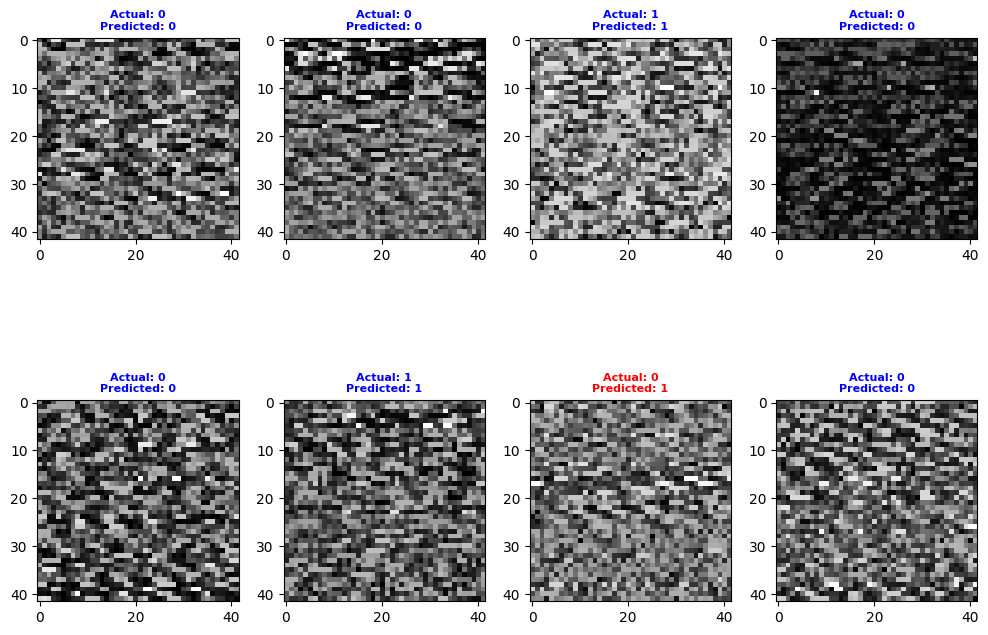

In [59]:
def reverse_lookup(index):
    return reverselookup[index]
num_samples_to_visualize = 8
random_indices = random.sample(range(len(X_test_hog)), num_samples_to_visualize)
x_random_samples = X_test_hog[random_indices]
y_random_labels = y_test[random_indices]
predictions_random = best_model.predict(x_random_samples)
num_rows = 2
num_cols = num_samples_to_visualize // num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        axes[i, j].imshow(x_random_samples[index].reshape(42, 42), cmap='gray')

        predicted_class = predictions_random[index] # Get predicted class directly
        actual_class = y_random_labels[index]
        # confidence = predictions_random[index][predicted_class] # Remove this line as it's causing the error

        title_color = 'blue' if predicted_class == actual_class else 'red'
        # Modified title without confidence
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nPredicted: {reverse_lookup(predicted_class)}',
                             color=title_color, backgroundcolor='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

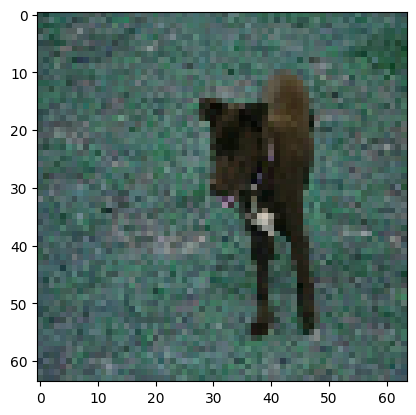

In [41]:
plt.imshow(X_test[0])
plt.show()